# Cosmics!

It's time to extract some cosmics from some darks to make training data. Let's do this.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize # For displaying the preproc images

import os
import re
import glob
import json
from pathlib import Path

# import joincosmics

In [10]:
# Took this from DESIspec.
def parse_sec_keyword(value):
    m = re.search(r'\[(\d+):(\d+)\,(\d+):(\d+)\]', value)
    if m is None:
        m = re.search(r'\[(\d+):(\d+)\, (\d+):(\d+)\]', value)
        if m is None :
            raise ValueError('unable to parse {} as [a:b, c:d]'.format(value))

    xmin, xmax, ymin, ymax = tuple(map(int, m.groups()))

    return np.s_[ymin - 1:ymax, xmin - 1:xmax]

# Subtracts off the bias overscan region to normalize the four quadrants.
def subtract_bias(img, camera):
    # Camera defines which camera to use, e.x. "R5"
    quads = ["A", "B", "C", "D"]
    corners = {}

    for q in quads:
        # Gets the data from the overscan region and subtracts the median from the data region.
        # More accurate would be to median each row or column etc but this is quick and dirty.
        o_i = parse_sec_keyword(hdus[camera].header["ORSEC" + q])
        d_i = parse_sec_keyword(hdus[camera].header["DATASEC" + q])
        overscan = img[o_i].copy()
        corners[q] = img[d_i] - np.median(overscan)
        
    # Smash the corners back together to make the large image.
    lower = np.concatenate((corners["A"], corners["B"]), axis=1)
    higher = np.concatenate((corners["C"], corners["D"]), axis=1)
    return np.concatenate((lower, higher), axis=0)

def pretty_disp(img):
    # Normalization to display the image nicer.
    zscale = ZScaleInterval()
    norm = ImageNormalize(img, zscale)

    fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
    ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)

In [5]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
ROOT_PRE = Path('/project/projectdirs/desi/spectro/redux/daily/preproc/')
assert ROOT.exists()

First we plot a zero to ensure that everything is working well. These are the kind of images we will be extracing the cosmics themselves from. I will be taking them out of the dark and overlaying them over the medians.

Filename: /project/projectdirs/desi/spectro/data/20191108/00025657/desi-00025657.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPS           1 CompImageHDU     55   (10,)   int16   
  2  Z2            1 CompImageHDU    137   (4256, 4194)   int16   
  3  R2            1 CompImageHDU    137   (4256, 4194)   int16   
  4  B2            1 CompImageHDU    137   (4232, 4162)   int16   
  5  Z7            1 CompImageHDU    137   (4256, 4194)   int16   
  6  R7            1 CompImageHDU    137   (4256, 4194)   int16   
  7  B7            1 CompImageHDU    137   (4232, 4162)   int16   
  8  Z6            1 CompImageHDU    137   (4256, 4194)   int16   
  9  R6            1 CompImageHDU    137   (4256, 4194)   int16   
 10  B6            1 CompImageHDU    137   (4232, 4162)   int16   
 11  Z0            1 CompImageHDU    137   (4256, 4194)   int16   
 12  R0            1 CompImageHDU    137   (4256, 4194)   int16   
 

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


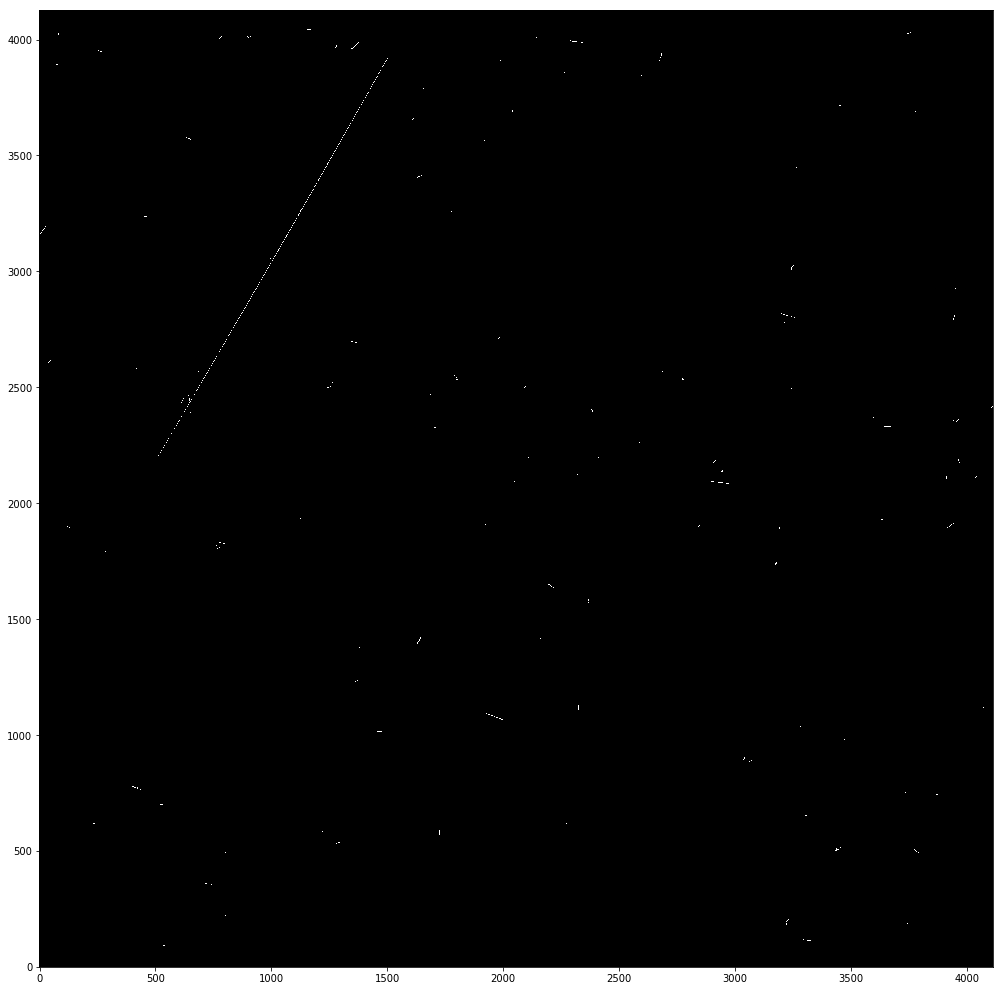

In [6]:
hdus = fits.open(os.path.join(ROOT, "20191108", "00025657", "desi-00025657.fits.fz"))
print(hdus.info())
img = hdus["R1"].data

# Subtract the bias to normalize everything.
img2 = subtract_bias(img, "R1") > 10

fig, ax = plt.subplots(1,1, figsize=(14,14), tight_layout=True)
ax.imshow(img2, cmap='gray', origin="lower", interpolation="none")

Load all the cosmics that we already extracted. See cosmic_extractor.ipynb for details on how this works.

In [6]:
cam = "R3"
cosmics = np.load("cosmic_data/cosmics.npy", allow_pickle=True)
cosmic_masks = np.load("cosmic_data/cosmic_masks.npy", allow_pickle=True)
cosmic_ivar = np.load("cosmic_data/cosmics_ivar.npy", allow_pickle=True)
exp_time = np.load("cosmic_data/exp.npy", allow_pickle=True)
nums = np.load("cosmic_data/nums.npy", allow_pickle=True)

print(len(cosmics))

43103


Plots the # of cosmics versus exposure time and finds the fit. The reason we do this is because when we generate the training data, we want to "simulate" an exposure time, which will naturally change the number of cosmics that end up in the resultant image. This fit is used to calculate the number of cosmics that we will overlay over the median.

46
46
60.0


/Users/dylan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app
/Users/dylan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


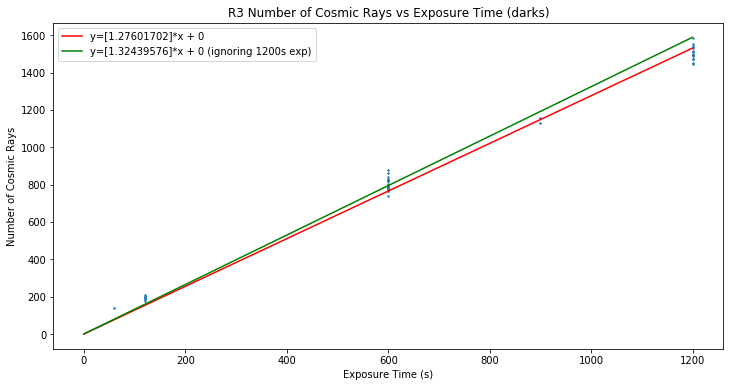

In [7]:
print(len(nums))
print(len(exp_time))
exp_time = np.asarray(exp_time)
print(np.min(exp_time))
nums = np.asarray(nums)

fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Exposure Time (s)")
plt.ylabel("Number of Cosmic Rays")
plt.scatter(exp_time, nums, s=2)

# Linear fits. m,b is non zero y intercept. a is forced 0 y intercept.
m,b = np.polyfit(exp_time, nums, 1)
x = np.asarray(exp_time).reshape(-1, 1)
a, _, _, _ = np.linalg.lstsq(x, nums)

# Plot the found fit above
x = np.arange(0, 1200, 1)
lbl = "y=" + str(a) + "*x + " + str(0)
plt.plot(x, a*x + 0, c='r', label= lbl)

# Finds the fit again but this time ignoring the 1200s exposures.
# We do this because at 1200s we expect the cosmics to start intersecting, so the # of cosmics
# will "taper off" at the high exposure times. 
exp_time2 = exp_time[exp_time < 1200]
nums2 = nums[exp_time < 1200]
m,b = np.polyfit(exp_time2, nums2, 1)
x = np.asarray(exp_time2).reshape(-1, 1)
a, _, _, _ = np.linalg.lstsq(x, nums2)

x = np.arange(0, 1200, 1)
lbl = "y=" + str(a) + "*x + " + str(0) + " (ignoring 1200s exp)"
plt.plot(x, a*x + 0, c='g', label= lbl)

plt.title(f"{cam} Number of Cosmic Rays vs Exposure Time (darks)")
plt.legend()
plt.savefig(f"{cam}-cosmics.png", dpi=256)

We wanna display a cosmic and the ivar for the cosmic to make sure we trimmed out the same thing in both.

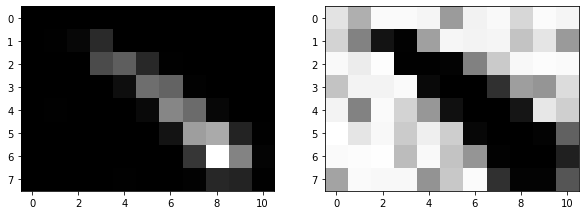

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cosmics[580], cmap="gray")
ax[1].imshow(cosmic_ivar[580], cmap="gray")

Displaying a clean median.

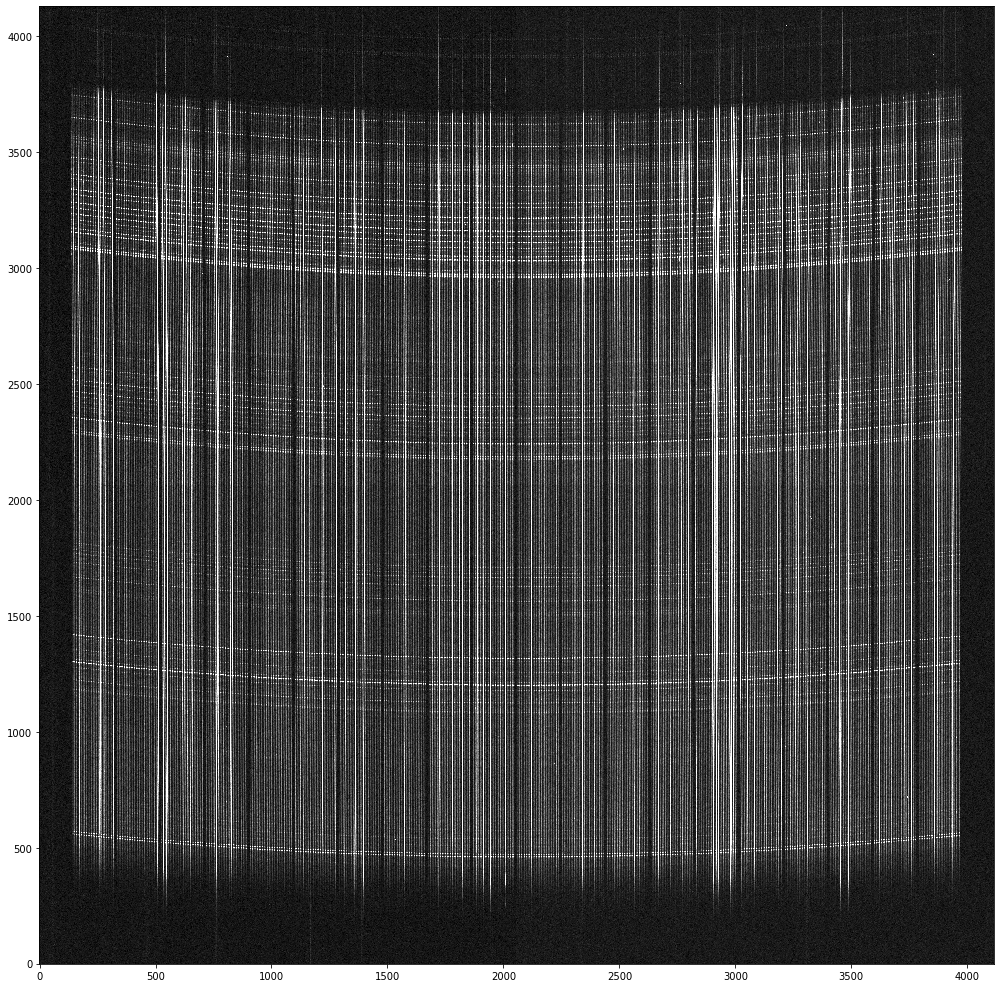

In [11]:
# Displaying final result for testing.
med_hdus = fits.open("medians/20200315RA=179.598729DEC=58.85798.fits.fz")
med_img = med_hdus["R1"].data
pretty_disp(med_img)

Displaying an image used in generating the previous median, so we can get a sense for what it "should" look like after we add some cosmics.

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


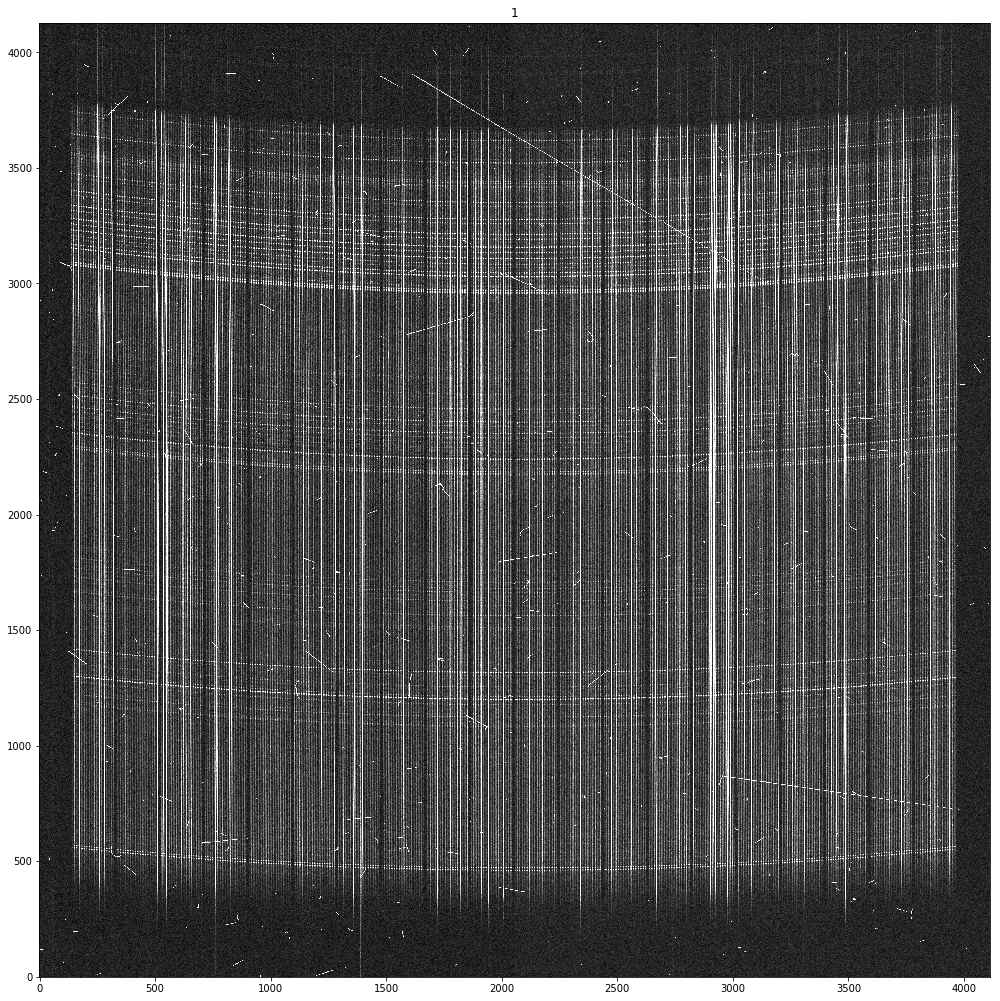

In [15]:
# Displaying a test image just in case.
hdus = fits.open(os.path.join(ROOT, "20200315", "00055654", "desi-00055654.fits.fz"))
img = hdus["R1"].data
img = subtract_bias(img, "R1")
# mask = hdus["MASK"].data

# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(img, zscale)

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title("1")
plt.savefig("test1.png", bbox_inches="tight")

Generate an array of random numbers, which correspond to indices for cosmics. These cosmics are then placed at random locations over the median image. The random generated locations all correspond to the top left corner of the cosmic. If the x or y coordinates of the cosmic bleed over the edge we move the top left corner far enough awawy from the edge to get the cosmic into the image. This will slightly reduce the randomness but presumably not to any noticable degree. Once complete we plot the new, completely fake, image!

In [13]:
num_cosmics = int(a * 600)
selected = np.random.rand(num_cosmics) * len(cosmics)
selected = selected.astype("int")

y_coords = np.random.rand(num_cosmics) * med_img.shape[0]
y_coords = y_coords.astype("int")
x_coords = np.random.rand(num_cosmics) * med_img.shape[1]
x_coords = x_coords.astype("int")

new_img = np.copy(med_img)

mask = np.zeros_like(new_img)

for i, cosmic_index in enumerate(selected):
    cosmic = cosmics[cosmic_index].astype(new_img.dtype)
    
    x_start = x_coords[i]
    y_start = y_coords[i]
    x_end = x_coords[i] + cosmic.shape[1]
    y_end = y_coords[i] + cosmic.shape[0]
    if y_end > new_img.shape[0]: 
        y_start = new_img.shape[0] - cosmic.shape[0] - 1
        y_end = -1
    if x_end > new_img.shape[1]:
        x_start = new_img.shape[1] - cosmic.shape[1] - 1
        x_end = -1
        
        
    new_img[y_start:y_end, x_start:x_end] += cosmic
    mask[y_start:y_end, x_start:x_end] += cosmic_masks[cosmic_index]

Text(0.5, 1.0, '2')

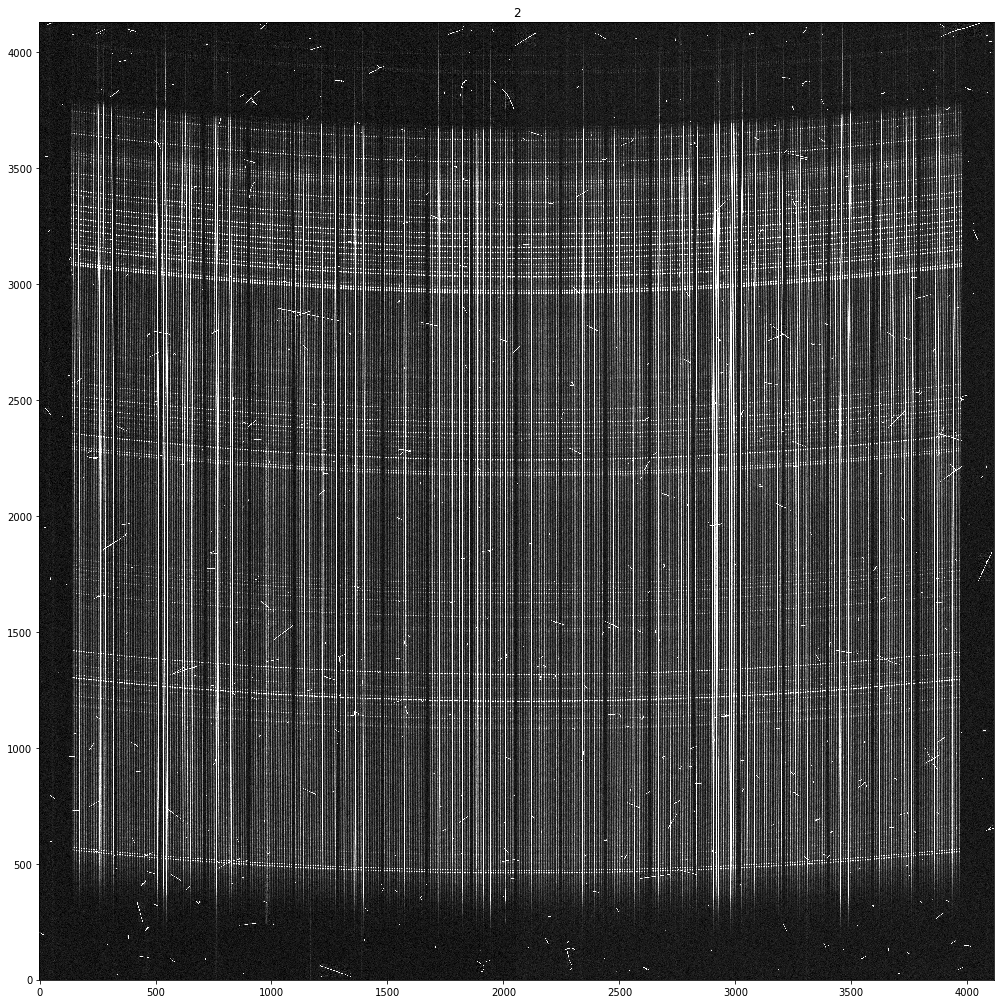

In [14]:
# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(new_img, zscale)

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(new_img, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title("2")
# plt.savefig("test2.png", bbox_inches="tight")

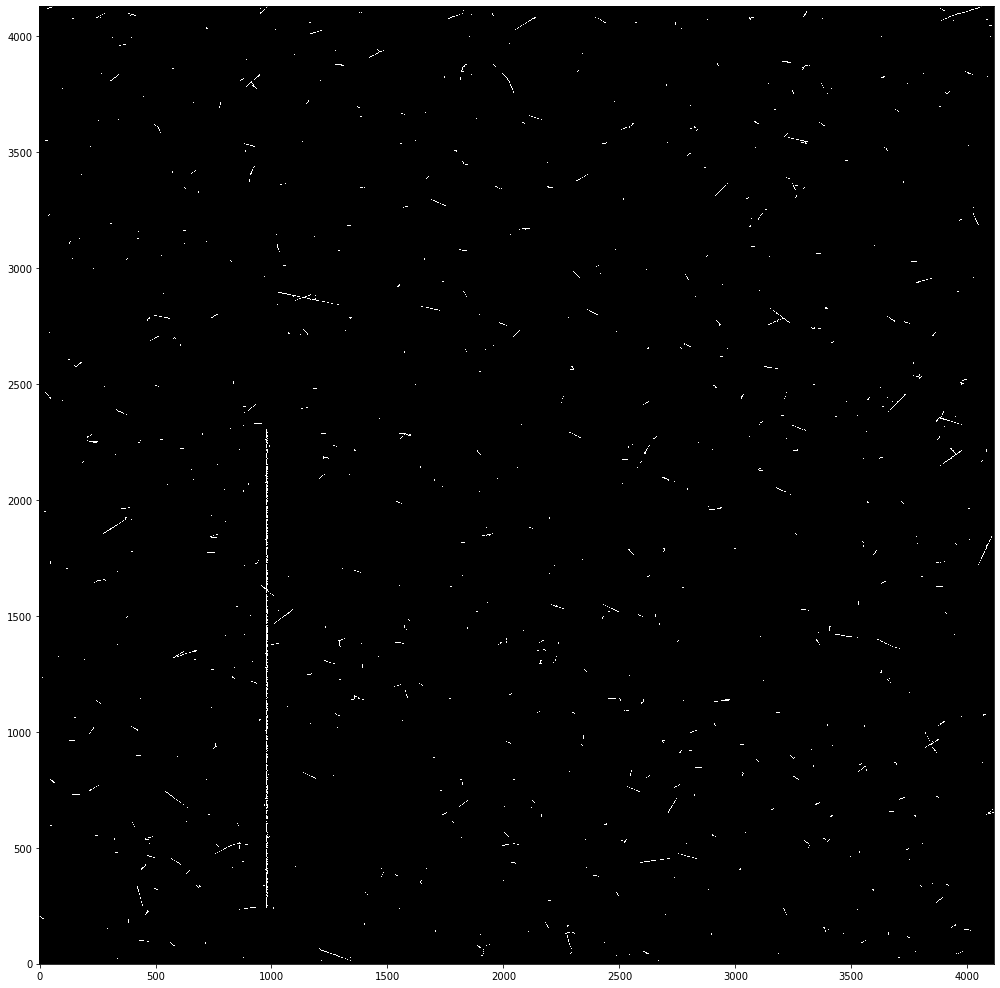

In [15]:
mask = mask > 0

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(mask, origin="lower", cmap="gray")

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


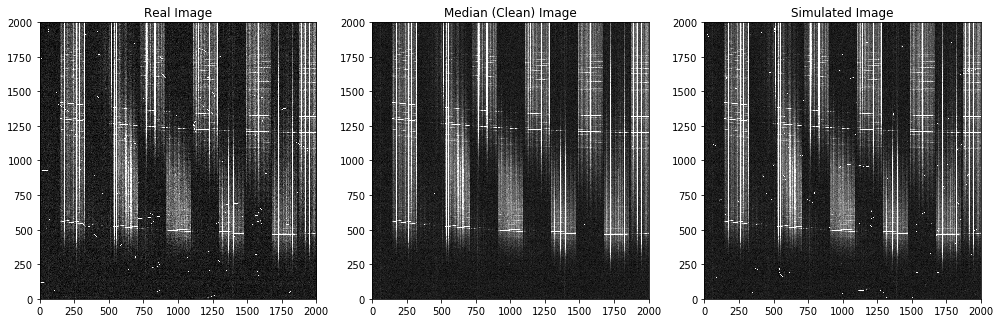

In [21]:
# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(new_img, zscale)

fig, ax = plt.subplots(1, 3, figsize=(14, 28), tight_layout=True)
ax[0].imshow(img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[0].set_title("Real Image")

ax[1].imshow(med_img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[1].set_title("Median (Clean) Image")

ax[2].imshow(new_img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[2].set_title("Simulated Image")

# fig.suptitle("Example Data")
plt.savefig("example_data.png", bbox_inches="tight", dpi=256)

In [16]:
def generate_training_image(input_img, input_ivar, num_cosmics):
    selected = np.random.rand(num_cosmics) * len(cosmics)
    selected = selected.astype("int")

    y_coords = np.random.rand(num_cosmics) * med_img.shape[0]
    y_coords = y_coords.astype("int")
    x_coords = np.random.rand(num_cosmics) * med_img.shape[1]
    x_coords = x_coords.astype("int")

    new_img = np.copy(input_img)
    new_ivar = np.copy(input_ivar)

    mask = np.zeros_like(new_img)

    for i, cosmic_index in enumerate(selected):
        cosmic = cosmics[cosmic_index].astype(new_img.dtype)

        x_start = x_coords[i]
        y_start = y_coords[i]
        x_end = x_coords[i] + cosmic.shape[1]
        y_end = y_coords[i] + cosmic.shape[0]
        if y_end > new_img.shape[0]: 
            y_start = new_img.shape[0] - cosmic.shape[0] - 1
            y_end = -1
        if x_end > new_img.shape[1]:
            x_start = new_img.shape[1] - cosmic.shape[1] - 1
            x_end = -1


        new_img[y_start:y_end, x_start:x_end] += cosmic# * 500
        mask[y_start:y_end, x_start:x_end] += cosmic_masks[cosmic_index]
        
        # Initializing to 0 because we want to maintain 0 ivars as 0
        # threse three lins initialize temp_ivar as 0s then inverts the values.
        # Anywhere where the value is 0, it is maintaned as 0 due to the where 
        # in the true divide.
        vals = new_ivar[y_start:y_end, x_start:x_end]
        temp_ivar = np.zeros_like(vals, dtype="float")
        np.true_divide(1, vals, out=temp_ivar, where=(vals!=0))
        
        # Now we do the same for the cosmic itself
        vals = cosmic_ivar[cosmic_index].astype(new_ivar.dtype)
        c_ivar = np.zeros_like(vals)
        np.true_divide(1, vals, out=c_ivar, where=(vals!= 0))
        
        # Once more to return to ivar
        temp_ivar = temp_ivar + c_ivar
        final_ivar = np.zeros_like(temp_ivar)
        np.true_divide(1, temp_ivar, out=final_ivar, where=(temp_ivar!= 0))
        
        new_ivar[y_start:y_end, x_start:x_end] = final_ivar
        
    return (new_img, new_ivar, mask)

In [18]:
num_training = 13

medians = os.listdir("medians")
# Linux can be stupid too.
if ".ipynb_checkpoints" in medians:
    medians.remove(".ipynb_checkpoints")

np.random.seed(0)
indices = np.random.rand(num_training) * len(medians)
indices = indices.astype("int16")

# Ten cameras and I want a good mix I guess lol
cams = np.random.rand(num_training) * 10
cams = cams.astype("int16")

for i in range(0, num_training):
    with fits.open(f"medians/{medians[indices[i]]}") as med_hdus:
        # Strips out all the cam names, sets them to empty string if its the ivars or not R band.
        # Then we kill the empty strings.
        cam_names = [med_hdus[i].name if (len(med_hdus[i].name) < 3 and med_hdus[i].name[0] == "R") else "" for i in range(0, len(med_hdus))]
        cam_names = [i for i in cam_names if i]

        # Super sloppy way to generate a single random number using the numpy random.
        # Why? Because I set the numpy random seed and I want this to be the same everytime lol.
        cam_ind = (np.random.rand(1) * len(cam_names)).astype("int16")[0]
        
        med_img = med_hdus[cam_names[cam_ind]].data
        ivar_img = med_hdus[f"{cam_names[cam_ind]}IVAR"].data

        num_cosmics = int(a * 600)

        new_img, new_ivar, mask = generate_training_image(med_img, ivar_img, num_cosmics)
        print(np.median(new_img[mask > 0]), np.mean(new_img[mask > 0]))

        hd0 = fits.PrimaryHDU()
        hd1 = fits.ImageHDU(new_img, name="IMAGE")
        hd2 = fits.ImageHDU(mask * 255, name="MASK")
        hd3 = fits.ImageHDU(new_ivar, name="IVAR")
        hdul = fits.HDUList([hd0, hd1, hd2, hd3])
        hdul.writeto(f"data/{i}-{cam_names[cam_ind]}.fits.fz", overwrite=True)

        print(f"Saved {i}-{cam_names[cam_ind]}.fits.fz")
print("Done!")

206.9835632625 418.7271464937211
Saved 0-R0.fits.fz
187.10108400000001 422.4768141769409
Saved 1-R4.fits.fz
108.996777 335.6990431925325
Saved 2-R3.fits.fz
98.98283553125 326.1251520347872
Saved 3-R1.fits.fz
202.7845296 428.4955811531495
Saved 4-R9.fits.fz
203.0189276 387.8035329098295
Saved 5-R1.fits.fz
182.46120635 411.1476171474859
Saved 6-R7.fits.fz
198.996777 398.7453667800092
Saved 7-R0.fits.fz
141.503119025 390.4610808591751
Saved 8-R9.fits.fz
210.1393496 453.8059930839037
Saved 9-R5.fits.fz
200.01716446875 412.9987844900101
Saved 10-R1.fits.fz
112.0140289625 352.42349784466455
Saved 11-R1.fits.fz
202.0 404.03038971179484
Saved 12-R4.fits.fz
Done!
